In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import pandas as pd
import tqdm
import seaborn as sns

In [2]:
from pymonntorch import *
from conex import *

# Rat Simulation

In [457]:
WINDOW_WIDTH = 50
WINDOW_HEIGHT = 50

window_x = [-WINDOW_WIDTH/2, +WINDOW_WIDTH/2]
window_y = [-WINDOW_HEIGHT/2, +WINDOW_HEIGHT/2]

def conv(angel) : 
    x = np.cos(np.radians(angel))
    y = np.sin(np.radians(angel))

    return x, y

def random_walk(length, R = 20,  initialize = True) : 

    if(initialize) : 
        pos_x = [0]
        pos_y = [0]

    theta = np.random.randint(0, 360)
    cnt = 0
    length_cnt = 0

    for _ in range(length) : 

        dist = np.sqrt(pos_x[-1]**2 + pos_y[-1]**2)
        # print(dist)
        if(dist > R) : 
            ang = np.angle(complex(pos_x[-1], pos_y[-1]), deg = True)
            theta = ang + np.random.randint(90, 180) % 360

        # theta = np.random.randint(0, 360)

        pos_x.append(pos_x[-1] + (conv(theta)[0] + 1/5 * np.random.uniform(-0.5,0.5)) * 1/10)
        pos_y.append(pos_y[-1] + (conv(theta)[1] + 1/5 * np.random.uniform(-0.5,0.5)) * 1/10)
            
    return pos_x, pos_y
    

def walk_initialize(length, theta = 0) : 

    pos_x = [0]
    pos_y = [0]

    cnt = 0
    length_cnt = 0

    for _ in range(length) : 
        # theta = np.random.randint(0, 360)

        pos_x.append(pos_x[-1] + (conv(theta)[0])/9)
        pos_y.append(pos_y[-1] + (conv(theta)[1])/9)
    
    pos_x = pos_x + pos_x[::-1][1:-1]
    pos_y = pos_y + pos_y[::-1][1:-1]
      
    return pos_x, pos_y

def generate_walk(length, R, theta = 0) : 
    init_x, init_y = walk_initialize(10, theta = theta)
    walk_x, walk_y = random_walk(length, R = 10)
    pos_x, pos_y = init_x + walk_x, init_y + walk_y

    return pos_x, pos_y

def generate_walk_multi(length, R, theta_lst, n = 1) :
    Px = []
    Py = []

    walk_x, walk_y = random_walk(length, R = 10)

    for i in range(n) : 
        init_x, init_y = walk_initialize(30, theta = theta_lst[i])
        pos_x, pos_y = init_x + walk_x, init_y + walk_y

        Px.append(pos_x)
        Py.append(pos_y)
    
    return Px, Py


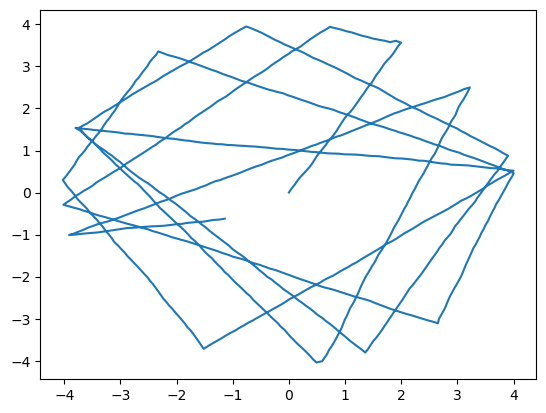

In [477]:
pos_x, pos_y = random_walk(1000, R = 4)
plt.plot(pos_x, pos_y, '-')
plt.show()

In [35]:
def speed_vector_converter(Xw, Yw) : 

    X = []
    Y = []

    for i in range(1, len(Xw)) : 
        X.append(Xw[i] - Xw[i - 1])
        Y.append(Yw[i] - Yw[i - 1])
    
    return (X, Y)

# L5/6 Grid-Place Cell

In [667]:
class GPCell(LIF) : 
    
    """
    Works as both L6 & L5 layers toghether as Grid-Place Cell getting speed vector as input.

    Args : 
        (float) L : The movement scaler, used as a scaler for the amount of effect the speed vector has on GPCells movement.
        (tuple) V : Speed-Vector throughout the iterations.
        (float) I_amp : Constant injected amplitude current.
    """

    def __init__(
        self,
        R,
        threshold,
        tau,
        v_reset,
        v_rest,
        *args,
        init_v=None,
        init_s=None,
        **kwargs
    ):
        super().__init__(
                *args,
                R=R,
                tau=tau,
                threshold=threshold,
                v_reset=v_reset,
                v_rest=v_rest,
                init_v=init_v,
                init_s=init_s,
                **kwargs
            )

    def initialize(self, neurons) :

        super().initialize(neurons)

        self.L = self.parameter("L", 1)
        self.V = self.parameter("V", required = True)
        self.I_amp = self.parameter("I_amp", 5)

        neurons.spike_prev = neurons.vector("zeros") < 0
    
    def forward(self, neurons) : 

        newPosX = neurons.x[neurons.spike_prev] + self.V[0][neurons.network.iteration] * self.L
        newPosX = ( (newPosX + torch.max(neurons.x) + torch.max(neurons.x)*2) % (torch.max(neurons.x) * 2)) - torch.max(neurons.x)
        newPosX = torch.round(newPosX)


        newPosY = neurons.y[neurons.spike_prev] + self.V[1][neurons.network.iteration] * self.L
        newPosY = ((newPosY + torch.max(neurons.y) + torch.max(neurons.y)*2) % (torch.max(neurons.y) * 2))  - torch.max(neurons.y)
        newPosY = torch.round(newPosY)

        inX = torch.isin(neurons.x, newPosX)
        inY = torch.isin(neurons.y, newPosY)

        # print("iteration :", neurons.network.iteration)
        # print("V: ", (self.V[0][neurons.network.iteration], self.V[1][neurons.network.iteration]))
        # print("prev X: ", neurons.x[neurons.spike_prev])
        # print("new X: ", newPosX)
        # print("-----------------------------------")

        # neurons.I += 1
        neurons.I[torch.logical_and(inX, inY)] += self.I_amp

        neurons.v += (
            (self._Fu(neurons) + self._RIu(neurons)) * neurons.network.dt / neurons.tau
        )

    def Fire(self, neurons) : 

        neurons.spikes = neurons.v >= neurons.threshold
        neurons.v[neurons.spikes] = neurons.v_reset

        neurons.spike_prev = neurons.spikes



In [668]:
class SampleAncher(Behavior) : 

    def initialize(self, neurons) : 
        neurons.I = neurons.vector("zeros")
        neurons.spikes = neurons.vector("zeros")
        neurons.v = neurons.vector(-80)

    def forward(self, neurons) : 
        if(neurons.network.iteration == 1) : 
            neurons.spikes = neurons.vector(1)
        else :
            neurons.spikes = neurons.vector(0)

In [669]:
class WeightInitializerAncher(Behavior) : 

    def initialize(self, synapse) : 

        synapse.weights = synapse.matrix("zeros")
        synapse.weights[0][(synapse.dst.x**2 + synapse.dst.y**2) <= 1**2] = 20

# CUSTOMIZATION

In [670]:
N = 25

In [688]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(dt = 1)
]))

ng = NeuronGroup(net = net, size = NeuronDimension(width = N, height = N), behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    Fire(),
    KWTA(k = 25),
    NeuronAxon()
]) | ({
    260 : GPCell(
        R = 10,
        tau = 5,
        threshold = -60,
        v_rest = -65,
        v_reset = -67,
        init_v =  -65,
        L = 7, 
        V = speed_vector_converter(pos_x, pos_y)
    ),
        
    600 : Recorder(["I", "v"]),
    601 : EventRecorder(['spikes'])
}))

inp = NeuronGroup(net = net, size = 1, behavior = prioritize_behaviors([
    SimpleDendriteStructure(),
    SimpleDendriteComputation(),
    NeuronAxon()
]) | ({
    260 : SampleAncher(),
    
    # 600 : Recorder(["I", "v"]),
    # 603 : EventRecorder(['spikes'])
}))

sg = SynapseGroup(net = net, src = inp, dst = ng, tag = "Proximal,exi", behavior = prioritize_behaviors([
    SynapseInit(),
    SimpleDendriticInput(),
]) | ({
    280 : WeightInitializerAncher(),
}))

In [689]:
net.initialize()
net.simulate_iterations(101)

Network['Network'](Neurons: tensor(626)|2 groups, Synapses: tensor(625)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](625){0:NeuronDimension(depth=1,height=25,width=25,input_patterns=None,)220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)260:GPCell(R=10,tau=5,threshold=-60,v_reset=-67,v_rest=-65,init_v=-65,init_s=None,L=7,V=([0.043688311484155994, 0.050142907672241895, 0.043603674867049, 0.05354843814483526, 0.058598881340774706, 0.05464363156205687, 0.05761847517486718, 0.05216732805666641, 0.04452785951882393, 0.04517414814691634, 0.05758742815958473, 0.0483875391573203, 0.046309635446003417, 0.041603468669784704, 0.05889880512316392, 0.051101002544232554, 0.04879496755652857, 0.04103353568180246, 0.04496350418238193, 0.04094168685720645, 0.054917

538.1393432617188

# Visualization

In [673]:
def iter_spike_multi_real(pos_x, pos_y, ng, itr, save = False, step = False, color = 'red', scale = 50, lib = "figs", label = "grid", offset_x = 0, offset_y = 0, base_offset_x = 0, base_offset_y = 0) :
    plt.xlim(-25, +25)
    plt.ylim(-25, +25)

    prev = max(0, itr*step - 30)

    ng_idx = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step][:,1]
    ng_idx_prev = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step - 4][:,1]
    ng_idx_prev_prev = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step - 8][:,1]

    pos_X = torch.Tensor(pos_x)
    pos_Y = torch.Tensor(pos_y)

    plt.plot((pos_X[prev:itr*step] + base_offset_x) * -1, (pos_Y[prev:itr*step] + base_offset_y) * -1, color = 'gray')
    
    # plt.plot((ng.x[ng_idx_prev_prev] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx_prev_prev] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, alpha = 0.2)
    # plt.plot((ng.x[ng_idx_prev] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx_prev] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, alpha = 0.35)
    plt.plot((ng.x[ng_idx] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, label = label, alpha = 1)
    plt.legend(loc = 'upper right')

    plt.plot((pos_x[itr*step] + base_offset_x) * -1, (pos_y[itr*step] + base_offset_y)* -1, '^', color = 'red', markersize = 10)

    plt.title(f"iteration = {itr * step}", y = -0.2)
    plt.suptitle("Grid Module Spikes")

    if(save) :
        plt.savefig("{}/fig{}.png".format(lib, itr))

<Axes: >

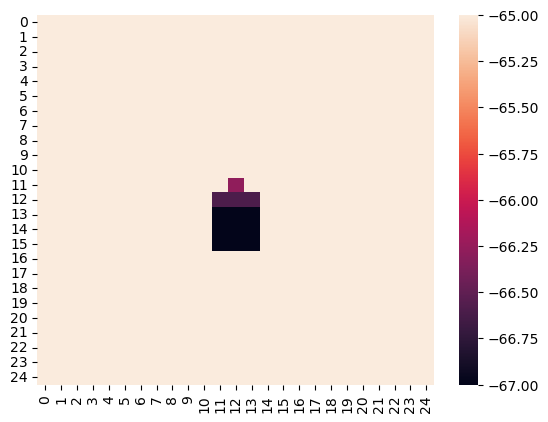

In [674]:
ng_I = ng["v", 0][3, :].view((ng.width, ng.height))
ng_I.shape
sns.heatmap(ng_I)

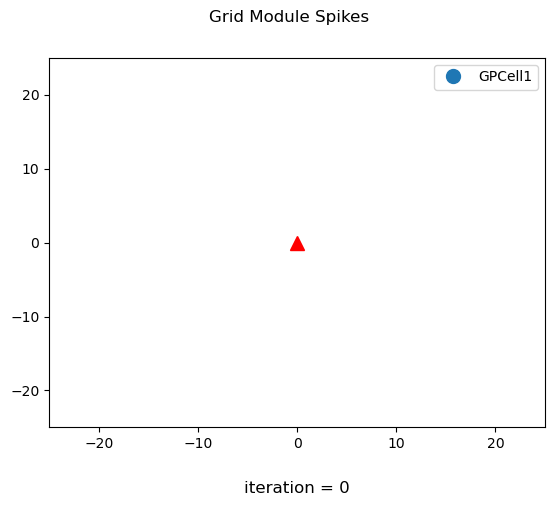

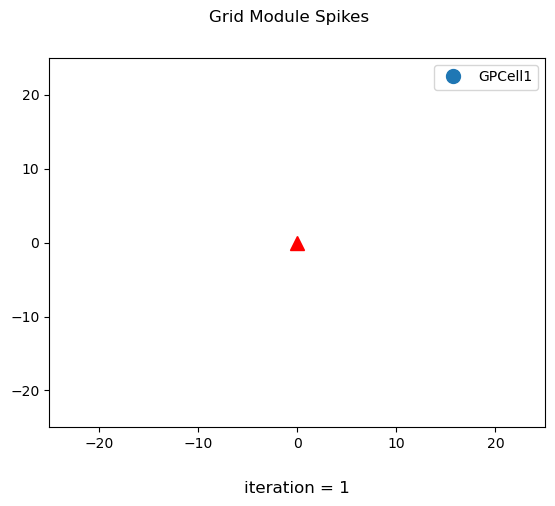

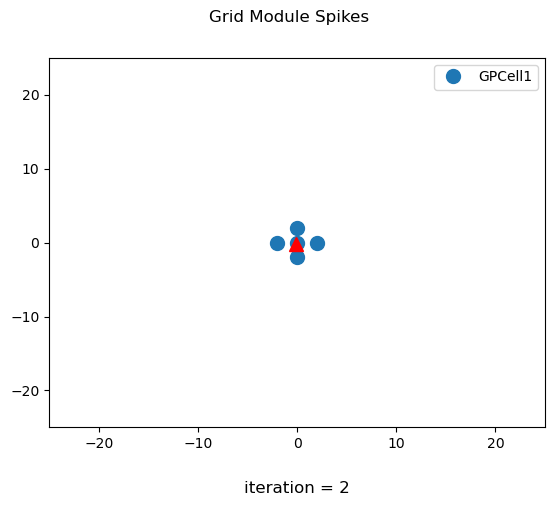

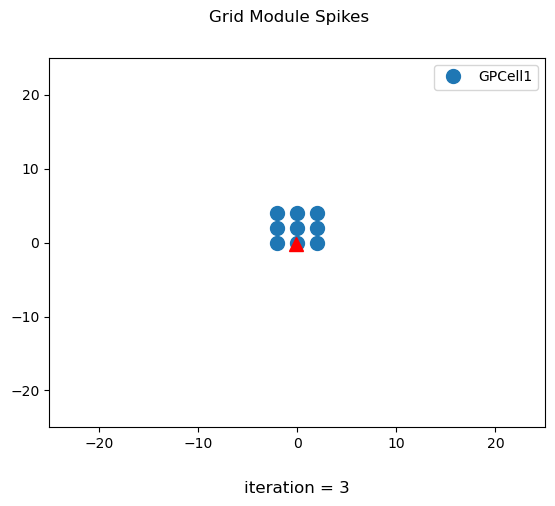

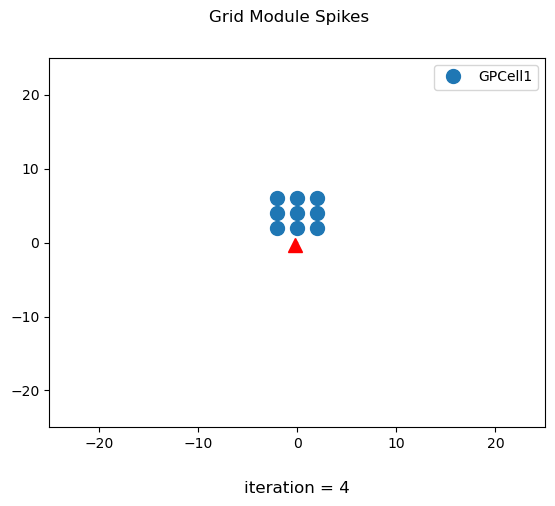

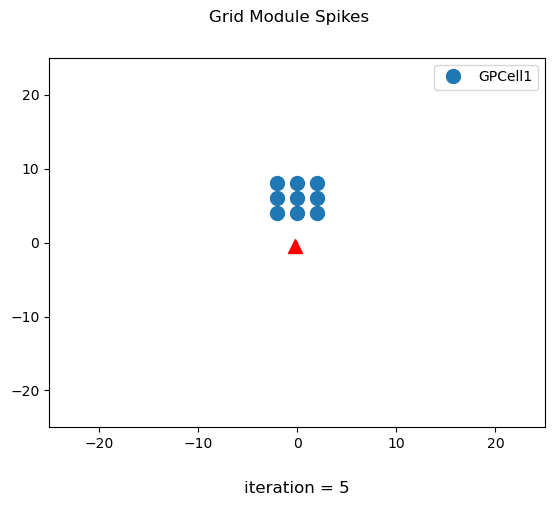

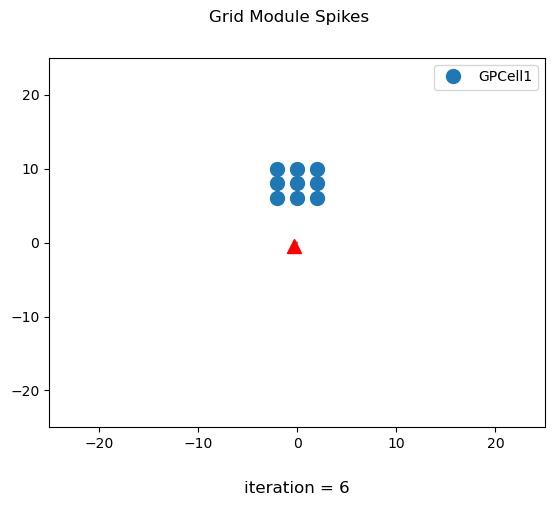

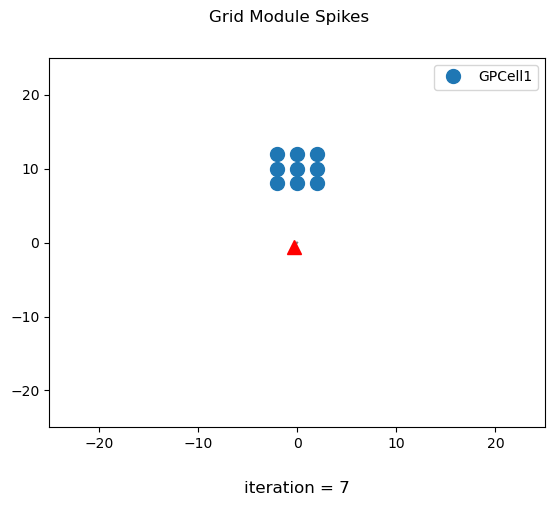

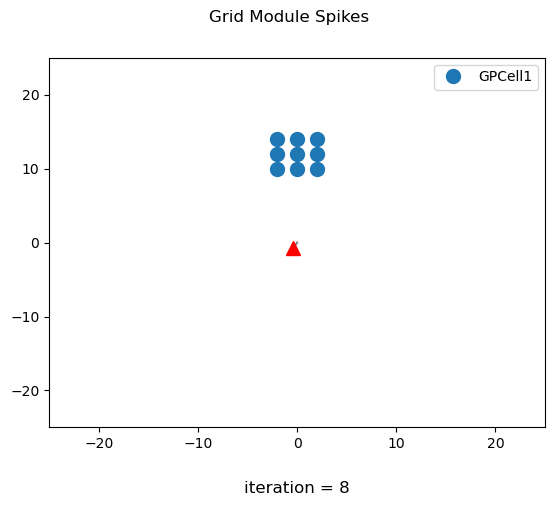

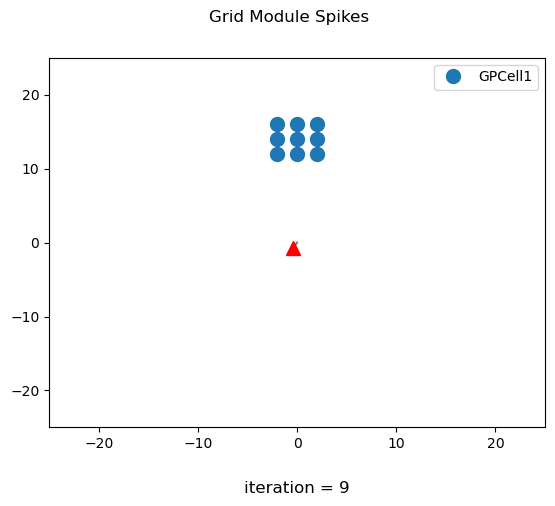

In [678]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = list(prop_cycle.by_key()['color'])


ngs = [ng]
for i in range(0, 10) :
    cnt = 0
    for ng in ngs : 
        iter_spike_multi_real(
            pos_x,
            pos_y,
            ng,
            itr = i, 
            step = 1, 
            color = colors[cnt], 
            save = False, 
            lib = "GPCell", 
            label = "GPCell" + str(cnt + 1), 
            offset_x = 0 , 
            offset_y = 0 ,
            base_offset_x = 0,
            base_offset_y = 0
            )
        cnt += 1
        # break
        
    plt.show()

# TODO LIST

### Implementation

* use **Pairwise Indexing** for new spiking neurons.
* use **Apical** synapses
* create multiple GDCells into a **layer**

* lateral inhitibtion (for each reference frame)
* KWTA fine-tuning

### Test

* check if the borders always **module (%)** the dimensions of neuron group.
* add a superfitial layer on top of GDCells to randomly prime the GDCell neurons


In [682]:
a = torch.Tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
a[[1, 1, 2], [0, 1, 1]]

tensor([4., 5., 8.])